Imports des librairies

In [ ]:
import pandas as pd

Première analyse des fichiers.

In [ ]:
# Dossier contenant les fichiers CSV
dossier = '../data/'

# Liste des années à vérifier
annees = list(range(2005, 2023))

# Liste des types de fichiers à lire
types_fichiers = ['caracteristiques', 'lieux', 'usagers', 'vehicules', 'vehicules-immatricules-baac']

# Initialisation de la liste pour stocker les résultats d'analyse
resultats_analyse = []

# Fonction pour lire les fichiers et extraire les informations
def analyser_fichier(chemin_fichier, type_fichier, annee):
    separateurs = [',', ';', '\t']
    for sep in separateurs:
        try:
            df = pd.read_csv(chemin_fichier, encoding='ISO-8859-1', delimiter=sep, on_bad_lines='skip', low_memory=False)
            if len(df.columns) > 1:
                stats_colonnes = {}
                for col in df.columns:
                    stats_colonnes[col] = {
                        'type': df[col].dtype,
                        'taux_nan': df[col].isna().mean() * 100,
                        'mode': df[col].mode().iloc[0] if not df[col].mode().empty else None,
                        'min': df[col].min() if df[col].dtype in ['float64', 'int64'] else None,
                        'max': df[col].max() if df[col].dtype in ['float64', 'int64'] else None,
                        'moyenne': df[col].mean() if df[col].dtype in ['float64', 'int64'] else None,
                        'mediane': df[col].median() if df[col].dtype in ['float64', 'int64'] else None,
                        'ecart_type': df[col].std() if df[col].dtype in ['float64', 'int64'] else None
                    }
                return {
                    'nom_fichier': f'{type_fichier}_{annee}.csv',
                    'chemin_fichier_complet': chemin_fichier,
                    'nombre_colonnes': len(df.columns),
                    'nombre_lignes': len(df),
                    'colonnes': df.columns.tolist(),
                    'statut': 'Succès',
                    'separateur': sep,
                    'stats_colonnes': stats_colonnes
                }
        except Exception:
            continue
    return {
        'nom_fichier': f'{type_fichier}_{annee}.csv',
        'chemin_fichier_complet': chemin_fichier,
        'nombre_colonnes': 1,
        'nombre_lignes': 0,
        'colonnes': [],
        'statut': 'Échec de lecture',
        'separateur': 'N/A',
        'stats_colonnes': {}
    }

# Analyse des fichiers et stockage des résultats
for type_fichier in types_fichiers:
    for annee in annees:
        chemin_fichier = f'{dossier}{type_fichier}_{annee}.csv'
        resultat = analyser_fichier(chemin_fichier, type_fichier, annee)
        resultat['type_fichier'] = type_fichier
        resultat['annee'] = annee
        resultats_analyse.append(resultat)

# Création d'un DataFrame pour les résultats d'analyse
analyse_df = pd.DataFrame(resultats_analyse)

# Extraction et structuration des statistiques de colonnes
stats_data = []
for resultat in resultats_analyse:
    for col, stats in resultat['stats_colonnes'].items():
        stats_data.append({
            'nom_fichier': resultat['nom_fichier'],
            'type_fichier': resultat['type_fichier'],
            'annee': resultat['annee'],
            'colonne': col,
            **stats
        })

# Création d'un DataFrame pour les statistiques de colonnes
stats_df = pd.DataFrame(stats_data)

# Export des résultats d'analyse et des statistiques en fichier Excel
with pd.ExcelWriter('resultats_analyse.xlsx') as writer:
    analyse_df.to_excel(writer, sheet_name='Résultats Analyse', index=False)
    stats_df.to_excel(writer, sheet_name='Stats Colonnes', index=False)

print("Export terminé.")


In [ ]:
analyse_df.head()

Analyse des colonnes

In [ ]:
# Initialisation du DataFrame final
informations_colonnes = []

# Filtrer le DataFrame pour ne conserver que les lignes où le statut est "Succès"
analyse_df_succes = analyse_df[analyse_df['statut'] == 'Succès']

# Parcourir chaque fichier dans le DataFrame filtré
for idx, row in analyse_df_succes.iterrows():
    chemin_fichier = row['chemin_fichier_complet']
    type_fichier = row['type_fichier']
    separateur = row['separateur']
    
    # Charger le fichier CSV
    try:
        df = pd.read_csv(chemin_fichier, sep=separateur, encoding='ISO-8859-1', low_memory=False)
        
        # Obtenir les informations sur les colonnes
        for col in df.columns:
            info_col = {
                'chemin_fichier_complet': chemin_fichier,
                'type_fichier': type_fichier,
                'nom_colonne': col,
                'nombre_lignes': len(df),
                'format': df[col].dtype
            }
            informations_colonnes.append(info_col)
    except Exception as e:
        print(f"Erreur lors de la lecture du fichier {chemin_fichier} : {e}")

# Créer le DataFrame final
analyse_colonnes_df = pd.DataFrame(informations_colonnes)

analyse_colonnes_df.head()


In [ ]:
analyse_colonnes_df.columns

DF Fusion_colonne par type de fichier avec somme sur nb de ligne et aggrégation sur format

In [ ]:
fusion_colonne = analyse_colonnes_df.groupby(['type_fichier', 'nom_colonne'], as_index=False).agg(
    nombre_lignes=('nombre_lignes', 'sum'),
    format=('format', lambda x: ','.join(sorted(set(str(i) for i in x)))),  # Convertir les valeurs en chaînes de caractères
)


In [ ]:
fusion_colonne.head()

In [ ]:
fusion_colonne[fusion_colonne['type_fichier'] == 'caracteristiques']

Attention Accident_id et Num_Acc à fusioner, attention aux formats différents

In [ ]:
fusion_colonne[fusion_colonne['type_fichier'] == 'lieux']

In [ ]:
fusion_colonne[fusion_colonne['type_fichier'] == 'usagers']

In [ ]:
fusion_colonne[fusion_colonne['type_fichier'] == 'vehicules']

Version 2 analyse en vue de concat et fusion

In [1]:
import pandas as pd

# Dossier contenant les fichiers CSV
dossier = '../data/'

# Liste des années à vérifier
annees = list(range(2005, 2023))

# Liste des types de fichiers à lire
types_fichiers = ['caracteristiques', 'lieux', 'usagers', 'vehicules', 'vehicules-immatricules-baac']

# Initialisation de la liste pour stocker les résultats d'analyse
resultats_analyse = []

# Dictionnaire pour stocker les DataFrames
dataframes = {}

# Fonction pour lire les fichiers et extraire les informations
def analyser_fichier(chemin_fichier, type_fichier, annee):
    separateurs = [',', ';', '\t']
    for sep in separateurs:
        try:
            df = pd.read_csv(chemin_fichier, encoding='ISO-8859-1', delimiter=sep, on_bad_lines='skip', low_memory=False)
            dataframes[f'{type_fichier}_{annee}'] = df  # Stocke le DataFrame dans le dictionnaire
            if len(df.columns) > 1:
                stats_colonnes = {}
                for col in df.columns:
                    stats_colonnes[col] = {
                        'type': df[col].dtype,
                        'taux_nan': df[col].isna().mean() * 100,
                        'mode': df[col].mode().iloc[0] if not df[col].mode().empty else None,
                        'min': df[col].min() if df[col].dtype in ['float64', 'int64'] else None,
                        'max': df[col].max() if df[col].dtype in ['float64', 'int64'] else None,
                        'moyenne': df[col].mean() if df[col].dtype in ['float64', 'int64'] else None,
                        'mediane': df[col].median() if df[col].dtype in ['float64', 'int64'] else None,
                        'ecart_type': df[col].std() if df[col].dtype in ['float64', 'int64'] else None
                    }
                return {
                    'nom_fichier': f'{type_fichier}_{annee}.csv',
                    'chemin_fichier_complet': chemin_fichier,
                    'nombre_colonnes': len(df.columns),
                    'nombre_lignes': len(df),
                    'colonnes': df.columns.tolist(),
                    'statut': 'Succès',
                    'separateur': sep,
                    'stats_colonnes': stats_colonnes
                }
        except Exception:
            continue
    return {
        'nom_fichier': f'{type_fichier}_{annee}.csv',
        'chemin_fichier_complet': chemin_fichier,
        'nombre_colonnes': 1,
        'nombre_lignes': 0,
        'colonnes': [],
        'statut': 'Échec de lecture',
        'separateur': 'N/A',
        'stats_colonnes': {}
    }

# Analyse des fichiers et stockage des résultats
for type_fichier in types_fichiers:
    for annee in annees:
        chemin_fichier = f'{dossier}{type_fichier}_{annee}.csv'
        resultat = analyser_fichier(chemin_fichier, type_fichier, annee)
        resultat['type_fichier'] = type_fichier
        resultat['annee'] = annee
        resultats_analyse.append(resultat)

# Création d'un DataFrame pour les résultats d'analyse
analyse_df = pd.DataFrame(resultats_analyse)

# Extraction et structuration des statistiques de colonnes
stats_data = []
for resultat in resultats_analyse:
    for col, stats in resultat['stats_colonnes'].items():
        stats_data.append({
            'nom_fichier': resultat['nom_fichier'],
            'type_fichier': resultat['type_fichier'],
            'annee': resultat['annee'],
            'colonne': col,
            **stats
        })

# Création d'un DataFrame pour les statistiques de colonnes
stats_df = pd.DataFrame(stats_data)

# Export des résultats d'analyse et des statistiques en fichier Excel
with pd.ExcelWriter('resultats_analyse.xlsx') as writer:
    analyse_df.to_excel(writer, sheet_name='Résultats Analyse', index=False)
    stats_df.to_excel(writer, sheet_name='Stats Colonnes', index=False)

print("Export terminé.")



Export terminé.


Concaténation

In [3]:


# Pour chaque type de fichier
for type_fichier in types_fichiers:
    # Initialiser une liste vide pour stocker les dataframes
    dfs = []

    # Parcourir les clés du dictionnaire
    for key in dataframes.keys():
        # Vérifier si la clé commence par le type de fichier
        if key.startswith(type_fichier):
            # Si c'est le cas, ajouter le dataframe à la liste
            dfs.append(dataframes[key])

    # Concaténer tous les dataframes de la liste en un seul
    # et stocker le résultat dans un nouveau dataframe
    globals()[f'df_concat_{type_fichier}'] = pd.concat(dfs)





In [5]:
df_concat_caracteristiques.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep,Accident_Id
0,2.005000e+11,5,1,12,1900,3,2,1,1.0,3.0,11.0,CD41B,M,5051500.0,294400.0,590,NaN
1,2.005000e+11,5,1,21,1600,1,2,1,1.0,1.0,51.0,rue de Lille,M,5053700.0,280200.0,590,NaN
2,2.005000e+11,5,1,21,1845,3,1,1,2.0,1.0,51.0,NaN,M,5054600.0,280000.0,590,NaN
3,2.005000e+11,5,1,4,1615,1,1,1,1.0,5.0,82.0,NaN,M,5098700.0,240800.0,590,NaN
4,2.005000e+11,5,1,10,1945,3,1,1,3.0,6.0,478.0,NaN,M,5096400.0,247500.0,590,NaN


In [7]:
df_concat_caracteristiques.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1176873 entries, 0 to 55301
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Num_Acc      1121571 non-null  float64
 1   an           1176873 non-null  int64  
 2   mois         1176873 non-null  int64  
 3   jour         1176873 non-null  int64  
 4   hrmn         1176873 non-null  object 
 5   lum          1176873 non-null  int64  
 6   agg          1176873 non-null  int64  
 7   int          1176873 non-null  int64  
 8   atm          1176800 non-null  float64
 9   col          1176854 non-null  float64
 10  com          1176871 non-null  object 
 11  adr          1032364 non-null  object 
 12  gps          480052 non-null   object 
 13  lat          689805 non-null   object 
 14  long         689801 non-null   object 
 15  dep          1176873 non-null  object 
 16  Accident_Id  55302 non-null    float64
dtypes: float64(4), int64(6), object(7)
memory usage: 161.

In [9]:
df_concat_lieux.head()

,Num_Acc,catr,voie,v1,v2,circ,nbv,pr,pr1,vosp,prof,plan,lartpc,larrout,surf,infra,situ,env1,vma
0,200500000001,3.0,41.0,0.0,B,2.0,2,1.0,430.0,0.0,1.0,1.0,0,63,1.0,0.0,1.0,0.0,NaN
1,200500000002,2.0,41.0,0.0,NaN,0.0,2,0.0,0.0,1.0,1.0,1.0,0,100,1.0,0.0,5.0,0.0,NaN
2,200500000003,2.0,41.0,0.0,NaN,0.0,0,0.0,0.0,1.0,1.0,1.0,0,0,2.0,0.0,5.0,0.0,NaN
3,200500000004,3.0,916.0,0.0,NaN,2.0,2,0.0,0.0,0.0,1.0,1.0,0,0,1.0,0.0,1.0,0.0,NaN
4,200500000005,3.0,110.0,0.0,NaN,2.0,2,24.0,630.0,0.0,1.0,3.0,0,59,2.0,0.0,3.0,0.0,NaN


In [11]:
df_concat_lieux.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1176873 entries, 0 to 55301
Data columns (total 19 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   Num_Acc  1176873 non-null  int64  
 1   catr     1176872 non-null  float64
 2   voie     1064888 non-null  object 
 3   v1       541049 non-null   float64
 4   v2       56624 non-null    object 
 5   circ     1175299 non-null  float64
 6   nbv      1174142 non-null  object 
 7   pr       701389 non-null   object 
 8   pr1      699570 non-null   object 
 9   vosp     1174112 non-null  float64
 10  prof     1174924 non-null  float64
 11  plan     1174592 non-null  float64
 12  lartpc   902767 non-null   object 
 13  larrout  1064032 non-null  object 
 14  surf     1174949 non-null  float64
 15  infra    1171465 non-null  float64
 16  situ     1171903 non-null  float64
 17  env1     953029 non-null   float64
 18  vma      218404 non-null   float64
dtypes: float64(11), int64(1), object(7)
memory usage:

In [13]:
df_concat_usagers.head()

,Num_Acc,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,num_veh,id_vehicule,secu1,secu2,secu3,id_usager
0,200500000001,1.0,1,4,1,1.0,11.0,0.0,0,0.0,1976.0,A01,NaN,NaN,NaN,NaN,NaN
1,200500000001,1.0,1,3,2,3.0,11.0,0.0,0,0.0,1968.0,B02,NaN,NaN,NaN,NaN,NaN
2,200500000001,2.0,2,1,1,0.0,11.0,0.0,0,0.0,1964.0,B02,NaN,NaN,NaN,NaN,NaN
3,200500000001,4.0,2,1,1,0.0,31.0,0.0,0,0.0,2004.0,B02,NaN,NaN,NaN,NaN,NaN
4,200500000001,5.0,2,1,1,0.0,11.0,0.0,0,0.0,1998.0,B02,NaN,NaN,NaN,NaN,NaN


In [15]:
df_concat_usagers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2636377 entries, 0 to 126661
Data columns (total 17 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Num_Acc      int64  
 1   place        float64
 2   catu         int64  
 3   grav         int64  
 4   sexe         int64  
 5   trajet       float64
 6   secu         float64
 7   locp         float64
 8   actp         object 
 9   etatp        float64
 10  an_nais      float64
 11  num_veh      object 
 12  id_vehicule  object 
 13  secu1        float64
 14  secu2        float64
 15  secu3        float64
 16  id_usager    object 
dtypes: float64(9), int64(4), object(4)
memory usage: 362.1+ MB


In [17]:
df_concat_vehicules.head()

,Num_Acc,senc,catv,occutc,obs,obsm,choc,manv,num_veh,id_vehicule,motor,Id_accident,Lettre Conventionnelle VÃ©hicule,AnnÃ©e,Lieu Admin Actuel - Territoire Nom,Type Accident - LibellÃ© (old),CNIT,CatÃ©gorie vÃ©hicule,Age vÃ©hicule,Type Accident - LibellÃ©
0,2.005000e+11,0.0,7.0,0.0,0.0,2.0,1.0,1.0,A01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.005000e+11,0.0,7.0,0.0,0.0,2.0,8.0,10.0,B02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.005000e+11,0.0,7.0,0.0,0.0,2.0,7.0,16.0,A01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.005000e+11,0.0,2.0,0.0,0.0,2.0,1.0,1.0,B02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.005000e+11,0.0,2.0,0.0,0.0,2.0,1.0,1.0,A01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_concat_vehicules.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3299602 entries, 0 to 89415
Data columns (total 20 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   Num_Acc                             float64
 1   senc                                float64
 2   catv                                float64
 3   occutc                              float64
 4   obs                                 float64
 5   obsm                                float64
 6   choc                                float64
 7   manv                                float64
 8   num_veh                             object 
 9   id_vehicule                         object 
 10  motor                               float64
 11  Id_accident                         object 
 12  Lettre Conventionnelle VÃ©hicule    object 
 13  AnnÃ©e                              float64
 14  Lieu Admin Actuel - Territoire Nom  object 
 15  Type Accident - LibellÃ© (old)      object 
 16  CNIT   

Fusion acc_id et Num_acc

In [21]:
# Remplacer les valeurs manquantes dans la colonne "Num_Acc" par les valeurs de la colonne "Accident_Id"
df_concat_caracteristiques['Num_Acc'].fillna(df_concat_caracteristiques['Accident_Id'], inplace=True)

# Supprimer la colonne "Accident_Id"
df_concat_caracteristiques.drop('Accident_Id', axis=1, inplace=True)


In [23]:
df_concat_caracteristiques.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep
0,2.005000e+11,5,1,12,1900,3,2,1,1.0,3.0,11.0,CD41B,M,5051500.0,294400.0,590
1,2.005000e+11,5,1,21,1600,1,2,1,1.0,1.0,51.0,rue de Lille,M,5053700.0,280200.0,590
2,2.005000e+11,5,1,21,1845,3,1,1,2.0,1.0,51.0,NaN,M,5054600.0,280000.0,590
3,2.005000e+11,5,1,4,1615,1,1,1,1.0,5.0,82.0,NaN,M,5098700.0,240800.0,590
4,2.005000e+11,5,1,10,1945,3,1,1,3.0,6.0,478.0,NaN,M,5096400.0,247500.0,590


jointure des df_concat

Avec celui qui a le plus de ligne en premier:
df_concat_vehicules: 3299602
df_concat_usagers: 2636377
df_concat_lieux: 1176873
df_concat_caracteristiques: 1176873


In [37]:



# Commencez avec un DataFrame
merge_df = df_concat_vehicules

# Fusionnez avec les autres DataFrames
merge_df = pd.merge(merge_df, df_concat_usagers, on='Num_Acc', how='inner')
merge_df = pd.merge(merge_df, df_concat_lieux, on='Num_Acc', how='inner')
merge_df = pd.merge(merge_df, df_concat_caracteristiques, on='Num_Acc', how='inner')


In [39]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5004843 entries, 0 to 5004842
Data columns (total 69 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   Num_Acc                             float64
 1   senc                                float64
 2   catv                                float64
 3   occutc                              float64
 4   obs                                 float64
 5   obsm                                float64
 6   choc                                float64
 7   manv                                float64
 8   num_veh_x                           object 
 9   id_vehicule_x                       object 
 10  motor                               float64
 11  Id_accident                         object 
 12  Lettre Conventionnelle VÃ©hicule    object 
 13  AnnÃ©e                              float64
 14  Lieu Admin Actuel - Territoire Nom  object 
 15  Type Accident - LibellÃ© (old)      object 
 16  

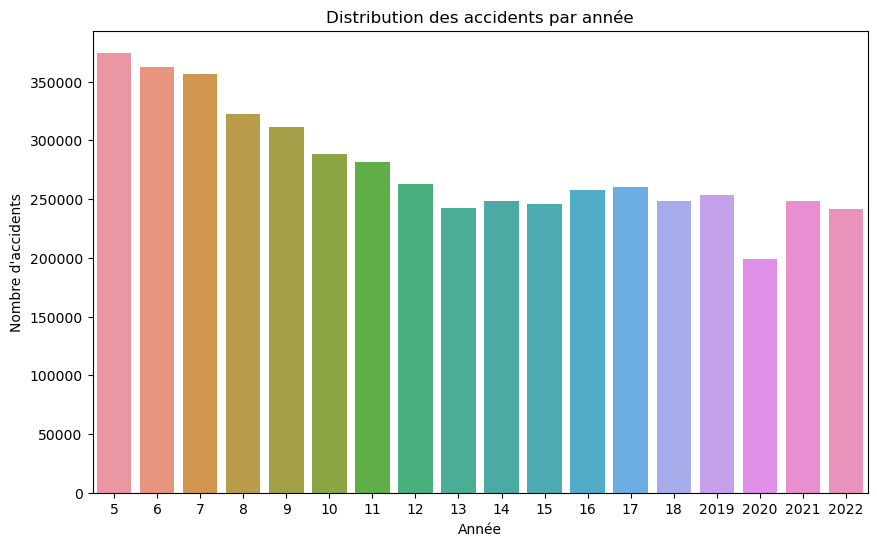

In [58]:
# Distribution des accidents par année
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=merge_df, x='an')
plt.title('Distribution des accidents par année')
plt.xlabel('Année')
plt.ylabel('Nombre d\'accidents')
plt.show()

AttributeError: 'numpy.int64' object has no attribute 'startswith'

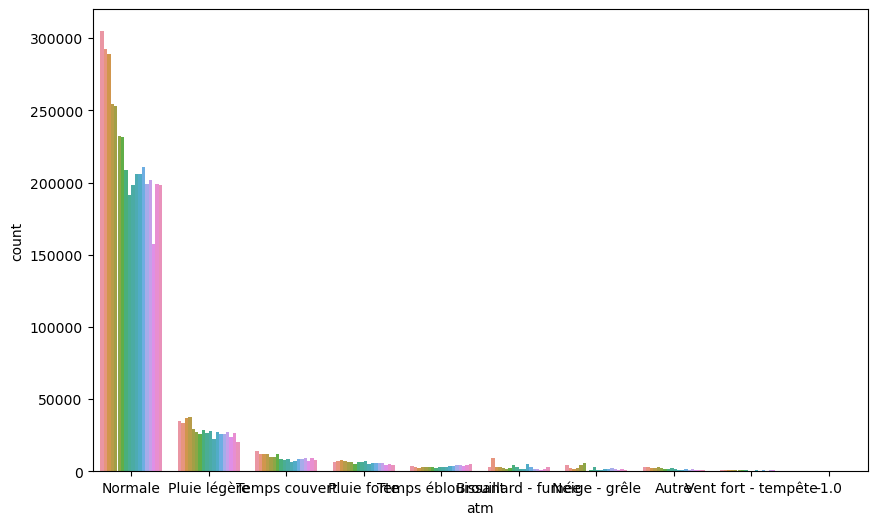

In [60]:
# Accidents par condition météorologique
val_atm = {1: 'Normale',
           2: 'Pluie légère',
           3: 'Pluie forte',
           4: 'Neige - grêle',
           5: 'Brouillard - fumée',
           6: 'Vent fort - tempête',
           7: 'Temps éblouissant',
           8: 'Temps couvert',
           9: 'Autre'}

merge_df['atm'] = merge_df['atm'].replace(val_atm)

plt.figure(figsize=(10, 6))
sns.countplot(data=merge_df, x='atm', hue='an', order=merge_df['atm'].value_counts().index)
plt.title('Accidents par condition météorologique')
plt.xlabel('Condition météorologique')
plt.ylabel('Nombre d\'accidents')
plt.xticks(rotation=45)
plt.show()